In [154]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "gene_families"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [155]:
chromsizes_str = """chr1	249250621
chr2	243199373
chr3	198022430
chr4	191154276
chr5	180915260
chr6	171115067
chr7	159138663
chrX	155270560
chr8	146364022
chr9	141213431
chr10	135534747
chr11	135006516
chr12	133851895
chr13	115169878
chr14	107349540
chr15	102531392
chr16	90354753
chr17	81195210
chr18	78077248
chr20	63025520
chrY	59373566
chr19	59128983
chr22	51304566
chr21	48129895"""

chromsizes = {}

for line in chromsizes_str.split("\n"):
    splits = line.strip().split("\t")
    chromsizes[splits[0]] = int(splits[1])

In [27]:
# plt.figure(figsize=(20, 5))
# sns.countplot(sub_clusters_regions['class type'])
# plt.xticks(rotation=90)

In [176]:
selected_classtype = 1.0

sub_clusters_regions = pd.read_excel(src.processed_data_path / "CuratedGeneFamilies_20190718.xlsx", sep="\t")
sub_clusters_regions = sub_clusters_regions.loc[sub_clusters_regions['class type'] == selected_classtype, src.coords].reset_index(drop=True).copy()
sub_clusters_regions['length'] = sub_clusters_regions.end - sub_clusters_regions.start
sub_clusters_regions['cluster_uid'] = sub_clusters_regions.index
sub_clusters_regions.head()

,chr,start,end,length,cluster_uid
0,chr1,152483320,152816459,333139,0
1,chr1,152943142,153177596,234454,1
2,chr1,171060018,171311223,251205,2
3,chr1,206940947,207077484,136537,3
4,chr1,207494853,207911761,416908,4


In [186]:
swapped = sub_clusters_regions.copy()
ends = swapped.apply(lambda x: chromsizes[x.chr] - x.start, axis=1)
starts = swapped.apply(lambda x: chromsizes[x.chr] - x.end, axis=1)

swapped['start'] = starts
swapped['end'] = ends
swapped.head()

,chr,start,end,length,cluster_uid
0,chr1,96434162,96767301,333139,0
1,chr1,96073025,96307479,234454,1
2,chr1,77939398,78190603,251205,2
3,chr1,42173137,42309674,136537,3
4,chr1,41338860,41755768,416908,4


In [187]:
sub_clusters_regions = swapped

In [132]:
# sub_clusters_regions = pd.read_csv(src.interim_data_path / "gene_families_subcluster_regions_CURATED.tsv", sep="\t")
# sub_clusters_regions.head()

In [188]:
extended = (2e6)
window_size = 5*1000

centered_sub_clusters_regions = sub_clusters_regions.copy()
centers = ((centered_sub_clusters_regions.start + centered_sub_clusters_regions.end)/2).astype(int)
centered_sub_clusters_regions['start'] = centers
centered_sub_clusters_regions['end'] = centers

centered_sub_clusters_regions = BedTool.from_dataframe(centered_sub_clusters_regions).slop(b=extended, genome='hg19').to_dataframe(names=centered_sub_clusters_regions.columns)
centered_sub_clusters_regions.head()

,chr,start,end,length,cluster_uid
0,chr1,94600731,98600731,333139,0
1,chr1,94190252,98190252,234454,1
2,chr1,76065000,80065000,251205,2
3,chr1,40241405,44241405,136537,3
4,chr1,39547314,43547314,416908,4


In [189]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep='\t')
ctcfs.head()

,chr,start,end,orientation,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,0,9.790746,12.637052,1.392043e+09
1,chr1,521337,521697,>,1,10.259412,13.835230,1.563464e+09
2,chr1,714087,714447,>,2,9.893988,9.332479,1.241503e+09
3,chr1,805232,805362,>,3,14.365820,46.633221,3.272974e+09
4,chr1,839966,840326,>,4,16.393501,60.461779,3.574601e+09


In [190]:
centered_sub_clusters_regions = centered_sub_clusters_regions[centered_sub_clusters_regions.end - centered_sub_clusters_regions.start == extended*2]
windows = src.windowing_by_size(centered_sub_clusters_regions[src.coords + ['cluster_uid']], window_size=window_size)
windows.head()

,chr,start,end,cluster_uid,w_num
0,chr1,39547314,39552314,4,0
1,chr1,39552314,39557314,4,1
2,chr1,39557314,39562314,4,2
3,chr1,39562314,39567314,4,3
4,chr1,39567314,39572314,4,4


In [191]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)

consensus_boundaries = pd.concat(
    (pd.DataFrame({
    'chr': consensus_boundaries.chr,
    'start': consensus_boundaries.start,
    'end': consensus_boundaries.start,
    'n_cell_types': consensus_boundaries.n_cell_types,
    'consensus_boundary_uid': consensus_boundaries.consensus_boundary_uid
    }), pd.DataFrame({
    'chr': consensus_boundaries.chr,
    'start': consensus_boundaries.end,
    'end': consensus_boundaries.end,
    'n_cell_types': consensus_boundaries.n_cell_types,
    'consensus_boundary_uid': consensus_boundaries.consensus_boundary_uid                                 
    })), axis=0)
consensus_boundaries = consensus_boundaries.sort_values(src.coords).reset_index(drop=True)
consensus_boundaries.head()

,chr,start,end,n_cell_types,consensus_boundary_uid
0,chr1,1612500,1612500,1,0
1,chr1,1612500,1612500,1,0
2,chr1,1646875,1646875,1,1
3,chr1,1646875,1646875,1,1
4,chr1,1842500,1842500,3,2


In [192]:
aggregations = {'orientation': 'collapse'}

windows_with_ctcfs = src.coverage_by_window(windows.sort_values(src.coords), ctcfs.sort_values(src.coords), aggregations)
windows_with_ctcfs = windows_with_ctcfs.merge(centered_sub_clusters_regions.drop(src.coords, axis=1), on='cluster_uid')
windows_with_ctcfs['value_orientation'] = windows_with_ctcfs['orientation'].map(lambda x: x.count(">") - x.count("<"))
windows_with_ctcfs.head()

,chr,start,end,cluster_uid,w_num,orientation,length,value_orientation
0,chr1,39547314,39552314,4,0,0,416908,0
1,chr1,39552314,39557314,4,1,>,416908,1
2,chr1,39557314,39562314,4,2,<,416908,-1
3,chr1,39562314,39567314,4,3,>,416908,1
4,chr1,39567314,39572314,4,4,>,416908,1


In [147]:
aggregations = {'n_cell_types': 'max'}

windows_with_bound = src.coverage_by_window(windows.sort_values(src.coords), consensus_boundaries.sort_values(src.coords), aggregations)
windows_with_bound = windows_with_bound.merge(centered_sub_clusters_regions.drop(src.coords, axis=1), on='cluster_uid')
windows_with_bound.head()

,chr,start,end,cluster_uid,w_num,n_cell_types,length
0,chr1,11291393,11296393,90,0,1,912819
1,chr1,11296393,11301393,90,1,1,912819
2,chr1,11301393,11306393,90,2,0,912819
3,chr1,11306393,11311393,90,3,0,912819
4,chr1,11311393,11316393,90,4,0,912819


In [148]:
sub_clusters_regions[sub_clusters_regions.cluster_uid == 90]

,chr,start,end,length,cluster_uid
90,chr1,12834984,13747803,912819,90


In [149]:
windows_with_clust = src.coverage_by_window(windows.sort_values(src.coords), sub_clusters_regions.rename(columns={'cluster_uid': 'ci'}).sort_values(src.coords), 
                                            {"ci": "distinct"})
windows_with_clust['ci'] = windows_with_clust.ci.map(lambda x: list(map(int,x.split(","))))
windows_with_clust['value'] = 0
windows_with_clust.loc[windows_with_clust.apply(lambda x: x.cluster_uid in x.ci, axis=1), 'value'] = 1
windows_with_clust.head()

,chr,start,end,cluster_uid,w_num,ci,value
0,chr1,11291393,11296393,90,0,[0],0
1,chr1,11296393,11301393,90,1,[0],0
2,chr1,11301393,11306393,90,2,[0],0
3,chr1,11306393,11311393,90,3,[0],0
4,chr1,11311393,11316393,90,4,[0],0


In [193]:
clust_vs_windows = windows_with_bound.pivot_table(index='cluster_uid', columns='w_num', values='n_cell_types')
length_vs_windows = windows_with_clust.pivot_table(index='cluster_uid', columns='w_num', values='value')
ctcfs_vs_windows = windows_with_ctcfs.pivot_table(index='cluster_uid', columns='w_num', values='value_orientation')

In [194]:
idx = sub_clusters_regions[sub_clusters_regions.cluster_uid.isin(centered_sub_clusters_regions.cluster_uid.tolist())]\
                    .sort_values('length', ascending=False).cluster_uid.tolist()

X = ctcfs_vs_windows.loc[idx].fillna(0).values

# min_cons = 4

# X[X < min_cons] = 0
# X[X >= min_cons] = 1

In [195]:
L = length_vs_windows.loc[idx].fillna(0).values

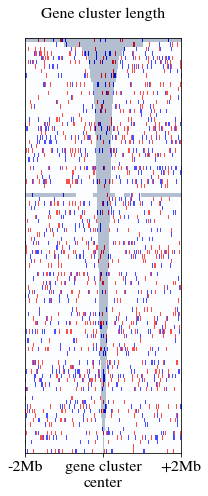

In [196]:
plt.figure(figsize=(3,7))
plt.imshow(L, aspect="auto", cmap='Blues', alpha=1)
plt.imshow(X, aspect="auto", alpha=0.7,cmap='bwr', vmin=-1, vmax=1)
plt.yticks([])
plt.xticks([0, int(X.shape[1]/2), X.shape[1] - 1], ['-2Mb', 'gene cluster\ncenter', "+2Mb"])
plt.title("Gene cluster length\n")
plt.show()